# 数据插值
---

插值是一种从离散数据点构建函数的数学方法。插值函数或者插值方法应该与给定的数据点完全一致。插值可能的应用场景：

1. 根据给定的数据集绘制平滑的曲线
2. 对计算量很大的复杂函数进行近似求值

插值和前面介绍过的最小二乘拟合有些类似。在最小二乘拟合中，我们感兴趣的是使用数据点和超定方程组，将函数拟合到数组点，使得误差平方和最小。在插值中，我们需要一个方程能够与已有的数据点完全重合，仅使用与插值函数自由参数个数相同的数据点。因此，最小二乘法适合将**大量数据点**拟合到模型函数，插值是根据**少量数据点**创建函数。

外插（extrapolation）是与插值（interpolation）相关的一个概念。外插是在采样范围之外计算函数的估计值。我们这里只介绍插值。

## 导入模块
---

本部分我们将使用NumPy中的polynomial模块和SciPy的interpolation模块。

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

from numpy import polynomial as P
from scipy import interpolate

In [1]:
%reload_ext version_information
%version_information numpy, matplotlib, scipy

Software versions
Python 3.9.7 64bit [GCC 9.4.0]
IPython 8.0.0
OS Linux 5.10.84 10.3.al8.x86_64 x86_64 with glibc2.32
numpy 1.21.2
matplotlib 3.5.1
scipy 1.5.3
Tue May 17 18:34:04 2022 CST

## 插值函数
---

为了简洁起见，我们这里只考虑一维插值问题。对于给定的数据点的集合 $\left\{ (x_i, y_i) \right \}_{i=1}^n$，找到插值函数$f(x_i)=y_i$。插值函数的选择并不是唯一的，事实上有无数函数满足插值标准。通常可以把插值函数写为一组基函数$\phi(x)$的线性组合，即$f(x)=\sum\limits_{j=1}^n c_j \phi_j(x)$，其中$c_j$是未知系数。将给定的数据点代入线性组合，可以得到未知系数的线性方程组：

$$
\begin{bmatrix}
\phi_1(x_1) & \phi_2(x_1) & \cdots & \phi_n(x_1) \\
\phi_1(x_2) & \phi_2(x_2) & \cdots & \phi_n(x_2) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_1(x_n) & \phi_2(x_n) & \cdots & \phi_n(x_n)
\end{bmatrix}
\begin{bmatrix}c_1 \\ c_2  \\ \vdots \\ c_n\end{bmatrix}
\begin{bmatrix}y_1 \\ y_2  \\ \vdots \\ y_n\end{bmatrix}
$$

这里基函数的数量与数据点的数量想用，可以使用求解方程组的标准方法得到系数向$c$的唯一解。如果基函数的数量小于数据点的数量，该方程组是超定的，可能需要使用最小二乘拟合进行近似插值。

基函数的选择会影响方程组的性质，合适的基函数取决于待拟合数据的属性。常见的插值基函数是各种类型的多项式，例如幂基函数$\phi_i(x) = x^{i-1}$，[勒让德多项式](https://zh.m.wikipedia.org/zh/勒让德多项式)$\phi_i(x) = P_{i-1}(x)$或分段多项式等。

## 多项式
---

NumPy库包含的polynominal模块提供了处理多项式的函数和类。要创建Polynominal类的实例，可以将系数数组传给该类的构造函数。

In [2]:
p1 = P.Polynomial([1,2,3])
p1

Polynomial([1., 2., 3.], domain=[-1,  1], window=[-1,  1])

也可以使用`Polynomial.fromroots`方法，通过指定多项式的根来初始化多项式。

In [3]:
p2 = P.Polynomial.fromroots([-1, 1])
p2

Polynomial([-1.,  0.,  1.], domain=[-1.,  1.], window=[-1.,  1.])

我们可以通过实例的方法访问其特性：

In [4]:
p1.roots() # 根

array([-0.33333333-0.47140452j, -0.33333333+0.47140452j])

In [5]:
p1.coef # 系数

array([1., 2., 3.])

Polynomial实例包括domain和windows两个参数，可以用于把多项式的输入域映射到另外一个区间。

In [6]:
p1.domain

array([-1,  1])

In [7]:
p1.window

array([-1,  1])

多项式在用Polynomial实例表示后可以很容易计算任何$x$的多项式值。

In [8]:
p1(np.array([1.5, 2.5, 3.5]))

array([10.75, 24.75, 44.75])

Polynomial实例支持标准的算术运算符。

In [5]:
p1 + p2

Polynomial([0., 2., 4.], domain=[-1.,  1.], window=[-1.,  1.])

In [10]:
p3 = P.Polynomial([1,1])  # 等价于 P.Polynomial.fromroots(-1)
p2 // p3

Polynomial([-1.,  1.], domain=[-1.,  1.], window=[-1.,  1.])

In [11]:
P.Polynomial.fromroots(-1)

Polynomial([1., 1.], domain=[-1.,  1.], window=[-1.,  1.])

除了标准幂基多项式的Polynomial类，polynomial模块还提供了切比雪夫多项式、勒让德多项式、拉盖尔多项式、埃尔米特多项式的类。

In [6]:
l1 = P.Legendre([1,2,3])  # 勒让德多项式
l1

Legendre([1., 2., 3.], domain=[-1,  1], window=[-1,  1])

In [13]:
l1.roots()

array([-0.62283903,  0.17839459])

## 多项式插值
---

求解多项式插值问题，首先需要根据提供的基函数计算矩阵$\phi(x)$，然后求解得到的线性方程组。polynomial模块中的每个多项式类都提供了方便的函数来计算相应基的[范德蒙矩阵](https://zh.m.wikipedia.org/zh/范德蒙矩陣)。

例如，假设存在数据点(1, 1)、(2, 3)、(3, 5)、(4, 4)。

In [7]:
x = np.array([1, 2, 3, 4])
y = np.array([1, 3, 5, 4])
deg = len(x) - 1
A = P.polynomial.polyvander(x, deg)  # 范德蒙矩阵
A

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.],
       [ 1.,  4., 16., 64.]])

In [9]:
c = linalg.solve(A, y)
c

array([ 2. , -3.5,  3. , -0.5])

找到的插值多项式是$f(x) = 2 - 3.5x + 3x^2 - 0.5 x^3$。

In [10]:
f1 = P.Polynomial(c)
f1(2.5)

4.187499999999998

下面，我们使用切比雪夫多项式重新对数据进行插值。

In [11]:
A = P.chebyshev.chebvander(x, deg)
A

array([[  1.,   1.,   1.,   1.],
       [  1.,   2.,   7.,  26.],
       [  1.,   3.,  17.,  99.],
       [  1.,   4.,  31., 244.]])

In [12]:
c = linalg.solve(A, y)
c

array([ 3.5  , -3.875,  1.5  , -0.125])

In [13]:
f2 = P.Chebyshev(c)
f2(2.5)

4.187499999999999

将函数$f1$和$f2$进行对比，验证不同基函数进行插值，得到了一致的插值函数。

Text(0.5, 0, '$x$')

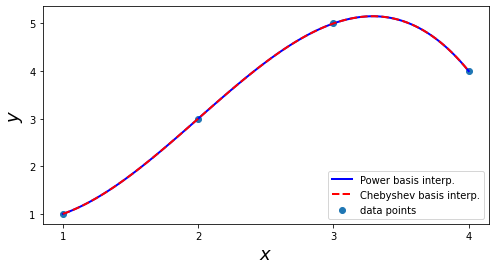

In [14]:
xx = np.linspace(x.min(), x.max(), 100)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(xx, f1(xx), 'b', lw=2, label='Power basis interp.')
ax.plot(xx, f2(xx), 'r--', lw=2, label='Chebyshev basis interp.')
ax.scatter(x, y, label='data points')

ax.legend(loc=4)
ax.set_xticks(x)
ax.set_ylabel(r"$y$", fontsize=18)
ax.set_xlabel(r"$x$", fontsize=18)

polynomial模块还提供了更快捷的方法计算插值多项式。每个多项式类都有fit方法用于计算插值，deg参数用于控制多项式的次数。如果多项式的次数少于数据点的数目减1，fit方法会使用最小二乘拟合而不是精确插值。

In [15]:
f1b = P.Polynomial.fit(x, y, deg)
f1b

Polynomial([ 4.1875,  3.1875, -1.6875, -1.6875], domain=[1., 4.], window=[-1.,  1.])

In [22]:
f2b = P.Chebyshev.fit(x, y, deg)
f2b

Chebyshev([ 3.34375 ,  1.921875, -0.84375 , -0.421875], domain=[1., 4.], window=[-1.,  1.])

**注意**在使用fit方法时，实例中的domain属性会自动设置为数据点中相应的x值，上述示例中为[1, 4]，并相应调整系数。将插值数据映射到某个基函数最合适的范围，可以明显提高插值的数值稳定性，减小范德蒙矩阵的条件数。

In [23]:
np.linalg.cond(P.chebyshev.chebvander(x, deg))

4659.738424140432

In [24]:
np.linalg.cond(P.chebyshev.chebvander((2*x-5)/3.0, deg))

1.8542033440472903

当数据点的数量增加时，需要使用次数更多的多项式才能得到精确的插值。这会带来多方面问题：
1. 次数更多的多项式插值计算和插值函数的确定，计算量很大。
2. 高次多项式插值可能会在插值点之间带来不可预料的行为，插值函数在数据点之间可能变化很大。

下面我们将使用龙格函数演示这种行为：

Text(0.5, 0, '$x$')

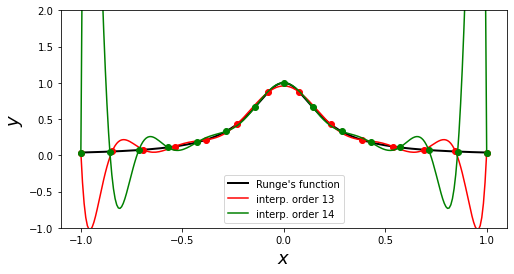

In [16]:
def runge(x):
    return 1/(1 + 25 * x**2)

def runge_interpolate(n):
    x = np.linspace(-1, 1, n+1)
    p = P.Polynomial.fit(x, runge(x), deg=n)
    return x, p

xx = np.linspace(-1, 1, 250)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(xx, runge(xx), 'k', lw=2, label="Runge's function")

n = 13
x, p = runge_interpolate(n)
ax.plot(x, runge(x), 'ro')
ax.plot(xx, p(xx), 'r', label='interp. order %d' % n)

n = 14
x, p = runge_interpolate(n)
ax.plot(x, runge(x), 'go')
ax.plot(xx, p(xx), 'g', label='interp. order %d' % n)

ax.legend(loc=8)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1, 2)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel(r"$y$", fontsize=18)
ax.set_xlabel(r"$x$", fontsize=18)

可以看到，高阶插值函数在远端采样点之间急剧震荡。这种不良特性违背了插值的初衷。一个可行的解决方法是，当面对大量数据点时，使用分段低次多项式进行插值。

## 样条插值
---

对于包含$n$个数据点的集合，在整个数据区间上有$n-1$个子区间。连接两个子区间的数据点在分段多项式插值中被称为节点。在每个子区间上使用$k$次多项式对$n$个数据点进行插值，需要确定$(k+1)(n-1)$个参数。所有节点的值可以给出$2(n-1)$个方程。为了保证分段多项式的平滑，节点处导数和高阶导数的连续性也会给出相应方程。

样条是一种特殊类型的分段式插值函数。最常用的是三次样条，$k=3$，需要$4(n-1)$个参数。在$n-2$个节点处，一阶和二阶导数的连续性可以给出$2(n-1)$个方程，总方程的数目为$4(n-1)-2$。此时还剩下两个未确定的参数。一种常见的方法是要求端点处的二阶导数为0，这被称为自然样条。

SciPy的interpolate模块提供了用于样条插值的多个函数和类。下面我们将再次使用龙格函数，演示使用`interpolate.interp1d`函数。这里设置kind=3来计算三次样条。

In [19]:
x = np.linspace(-1, 1, 11)
y = runge(x)
f = interpolate.interp1d(x, y, kind=3)
f(0.05)

array(0.94832503)

Text(0.5, 0, '$x$')

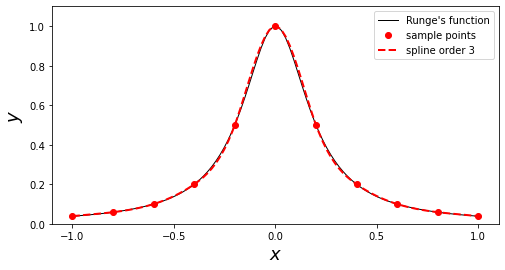

In [20]:
xx = np.linspace(-1, 1, 100)
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(xx, runge(xx), 'k', lw=1, label="Runge's function")
ax.plot(x, y, 'ro', label='sample points')
ax.plot(xx, f(xx), 'r--', lw=2, label='spline order 3')

ax.legend()
ax.set_ylim(0, 1.1)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel(r"$y$", fontsize=18)
ax.set_xlabel(r"$x$", fontsize=18)

这里使用了11个数据点和三次样条，可以看到插值很好地与原始函数吻合。

为了说明阶数对样条插值的影响，我们下面准备了8个数据点使用不同阶数的样条进行插值。

Text(0.5, 0, '$x$')

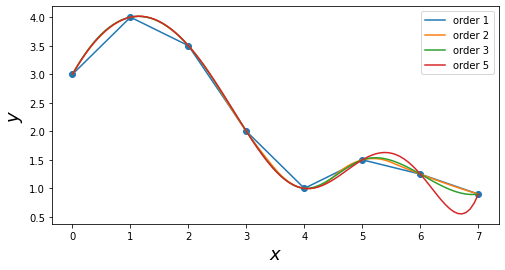

In [21]:
x = np.array([0, 1, 2, 3, 4, 5, 6, 7])
y = np.array([3, 4, 3.5, 2, 1, 1.5, 1.25, 0.9])

xx = np.linspace(x.min(), x.max(), 100)

fig, ax = plt.subplots(figsize=(8, 4))

ax.scatter(x, y)

for n in [1, 2, 3, 5]:
    f = interpolate.interp1d(x, y, kind=n)
    ax.plot(xx, f(xx), label='order %d' % n)

ax.legend()
ax.set_ylabel(r"$y$", fontsize=18)
ax.set_xlabel(r"$x$", fontsize=18)

可以看到，二阶或三阶样条已经能够提供较好的插值。高阶样条会出现高阶多项式插值中类似的数值震荡问题。

## 多变量插值
---

多项式插值和样条插值都可以直接推广到多变量情况。SciPy为多变量插值提供了多个函数和类。我们将介绍两个最常用的双变量插值函数：`interpolate.interp2d`和`interpolate.griddata`。

### 均匀网格

`interpolate.interp2d`函数是`interpolate.interp1d`函数的推广，要求数据点位于x和y坐标组成的规则且均匀的网格中。

为了演示函数用法，我们在已知函数
$$f(x, y) = \exp(-(x+1/2)^2 - 2(y+1/2)^2) -  \exp(-(x-1/2)^2 - 2(y-1/2)^2)$$
中添加随机噪声来模拟测量噪声。为了构造插值问题，我们在x和y坐标的[-2, 2]区间上采样10个点。


In [22]:
def f(x, y):
    return np.exp(-(x + .5)**2 - 2*(y + .5)**2) - np.exp(-(x - .5)**2 - 2*(y - .5)**2)

x = y = np.linspace(-2, 2, 10)
X, Y = np.meshgrid(x, y)
# simulate noisy data at fixed grid points X, Y
Z = f(X, Y) + 0.05  * np.random.randn(*X.shape)

In [23]:
f_interp = interpolate.interp2d(x, y, Z, kind='cubic')  # 三次样条插值

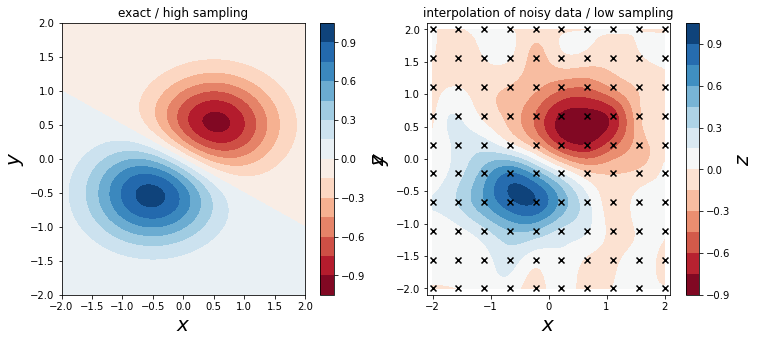

In [24]:
xx = yy = np.linspace(x.min(), x.max(), 100)
ZZ_interp = f_interp(xx, yy)
XX, YY = np.meshgrid(xx, yy)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

c = axes[0].contourf(XX, YY, f(XX, YY), 15, cmap=plt.cm.RdBu)
axes[0].set_xlabel(r"$x$", fontsize=20)
axes[0].set_ylabel(r"$y$", fontsize=20)
axes[0].set_title("exact / high sampling")
cb = fig.colorbar(c, ax=axes[0])
cb.set_label(r"$z$", fontsize=20)

c = axes[1].contourf(XX, YY, ZZ_interp, 15, cmap=plt.cm.RdBu)
axes[1].set_ylim(-2.1, 2.1)
axes[1].set_xlim(-2.1, 2.1)
axes[1].set_xlabel(r"$x$", fontsize=20)
axes[1].set_ylabel(r"$y$", fontsize=20)
axes[1].scatter(X, Y, marker='x', color='k')
axes[1].set_title("interpolation of noisy data / low sampling")
cb = fig.colorbar(c, ax=axes[1])
cb.set_label(r"$z$", fontsize=20)

对于更高维的问题，可以使用`interpolate.interpnd`函数，它是对N维问题的推广。

### 不均匀网格

另一种多变量插值的常见场景是从不规则的坐标网络中采样数据，例如实验室数据等。为了能够使用现有的工具对数据进行可视化分析，可能需要将它们插值到规则的坐标网格中。

在SciPy中，可以使用`interpolate.griddata`函数来完成这项工作。该函数的第一个参数是坐标向量构成的元组，第二个参数是对应的数据点的值，第三个参数是待插值的新数据点的坐标数组或坐标矩阵。

我们考虑函数$f(x, y) = \exp(-x^2-y^2) \cos 4x \sin 6y$在x和y坐标区间[-1, 1]上随机选择的采样点，并对采样数据进行插值。

In [25]:
def f(x, y):
    return np.exp(-x**2 - y**2) * np.cos(4*x) * np.sin(6*y)

x = y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

In [26]:
np.random.seed(0)
N = 500
xdata = np.random.uniform(-1, 1, N)
ydata = np.random.uniform(-1, 1, N)
zdata = f(xdata, ydata)

我们画出函数$f(x, y)$的等高线图，以及500个采样点的位置。

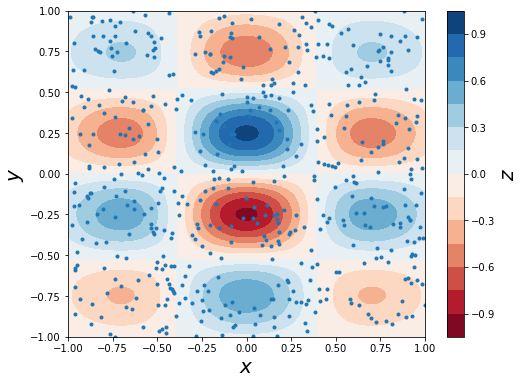

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.contourf(X, Y, Z, 15, cmap=plt.cm.RdBu);
ax.scatter(xdata, ydata, marker='.')
ax.set_ylim(-1,1)
ax.set_xlim(-1,1)
ax.set_xlabel(r"$x$", fontsize=20)
ax.set_ylabel(r"$y$", fontsize=20)

cb = fig.colorbar(c, ax=ax)
cb.set_label(r"$z$", fontsize=20)

随后，我们使用X和Y坐标数组定义更细小间隔（超采样）的网格中对数据进行插值。我们将比较最近邻点插值（0阶插值）、线性插值（1阶插值）和三次样条插值在不用数据点数目下的效果区别。

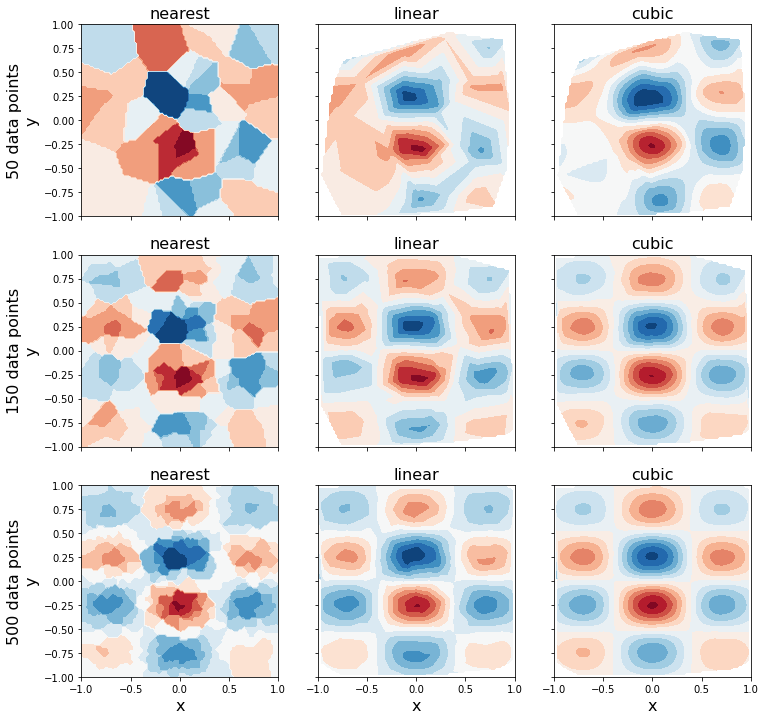

In [28]:
def z_interpolate(xdata, ydata, zdata):
    Zi_0 = interpolate.griddata((xdata, ydata), zdata, (X, Y), method='nearest')
    Zi_1 = interpolate.griddata((xdata, ydata), zdata, (X, Y), method='linear')
    Zi_3 = interpolate.griddata((xdata, ydata), zdata, (X, Y), method='cubic')
    return Zi_0, Zi_1, Zi_3

fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

n_vec = [50, 150, 500]

for idx, n in enumerate(n_vec):
    Zi_0, Zi_1, Zi_3 = z_interpolate(xdata[:n], ydata[:n], zdata[:n])
    axes[idx, 0].contourf(X, Y, Zi_0, 15, cmap=plt.cm.RdBu)
    axes[idx, 0].set_ylabel("%d data points\ny" % n, fontsize=16)
    axes[idx, 0].set_title("nearest", fontsize=16)
    axes[idx, 1].contourf(X, Y, Zi_1, 15, cmap=plt.cm.RdBu)
    axes[idx, 1].set_title("linear", fontsize=16)
    axes[idx, 2].contourf(X, Y, Zi_3, 15, cmap=plt.cm.RdBu)
    axes[idx, 2].set_title("cubic", fontsize=16)

for m in range(len(n_vec)):
    axes[idx, m].set_xlabel("x", fontsize=16)

只要采样点能够有效覆盖我们感兴趣的区域，就可以通过非结构化的样本数据进行插值来重建函数。上面例子中，三次样条插值的效果要远优于最近邻点插值和线性插值。